# Measure Intensity of sound using ``pyaudio``
- More info on Pyaudio in [here](https://www.swharden.com/wp/2016-07-19-realtime-audio-visualization-in-python)
- Info in Python formatting [here](https://pyformat.info)
- Matplotlib plotting [here](https://www.tutorialspoint.com/numpy/numpy_matplotlib.htm) and [here](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplot.html)
- Wave intensity reference [here](https://physics.info/intensity)
### Objective:
- ▣ Connect two mics such that the sound can be recorded in two channels
- ▣ Measure intensity of the sound captured by twoI \propto (\Delta s)^2 microphones
    - ▣ Decide whether to use $I \propto (\Delta s)^2$ or $I \propto (\Delta s)$ relationship (I think the **raw data** is better for the algorithm)
- ▢

In [ ]:
import pyaudio
import numpy as np
from matplotlib import pyplot as plt 
from IPython.display import clear_output
import keyboard
%matplotlib notebook

### Seperating even and odd index

In [2]:
p = [0,1,2,3,4,5,6,7,8,9,10]
a=p[0::2]
b=p[1::2]
a,b

([0, 2, 4, 6, 8, 10], [1, 3, 5, 7, 9])

### PyAudio input device Info

In [2]:
p=pyaudio.PyAudio()
p.get_default_input_device_info()

{'index': 1,
 'structVersion': 2,
 'name': 'Microphone (Realtek Audio)',
 'hostApi': 0,
 'maxInputChannels': 2,
 'maxOutputChannels': 0,
 'defaultLowInputLatency': 0.09,
 'defaultLowOutputLatency': 0.09,
 'defaultHighInputLatency': 0.18,
 'defaultHighOutputLatency': 0.18,
 'defaultSampleRate': 44100.0}

### Recording a sample using both channels

<IPython.core.display.Javascript object>


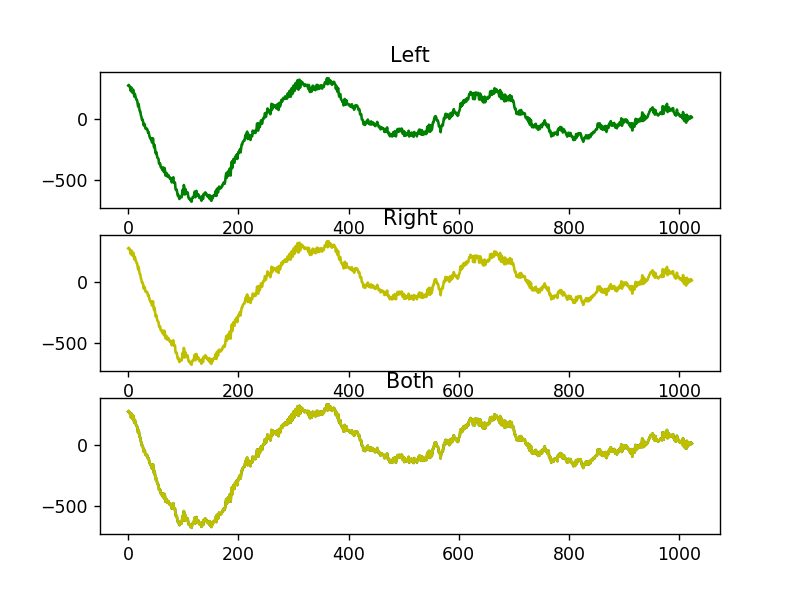

In [3]:
CHUNK = 1024
RATE = 44100
CHANNELS = 2
FORMAT = pyaudio.paInt16

p=pyaudio.PyAudio()
stream=p.open(format=FORMAT,
              channels=CHANNELS,
              rate=RATE,
              input=True, 
              frames_per_buffer=CHUNK
             )
# convert string data into integer
data = np.fromstring(stream.read(CHUNK),dtype=np.int16)

# Since the data has both channel info need to split them
dataL = data[0::2]  # select even index
dataR = data[1::2]  # select odd index

xL = np.arange(0,len(dataL))
xR = np.arange(0,len(dataR))

plt.subplot(3, 1, 1)
plt.plot(xL,dataL,color='g')
plt.title('Left') 

plt.subplot(3, 1, 2)
plt.plot(xR,dataR,color='y')
plt.title('Right') 

plt.subplot(3, 1, 3)
plt.title('Both') 
plt.plot(xR,dataL,color='g')
plt.plot(xL,dataR,color='y')

plt.show()


### Real-time audio visialization

<IPython.core.display.Javascript object>


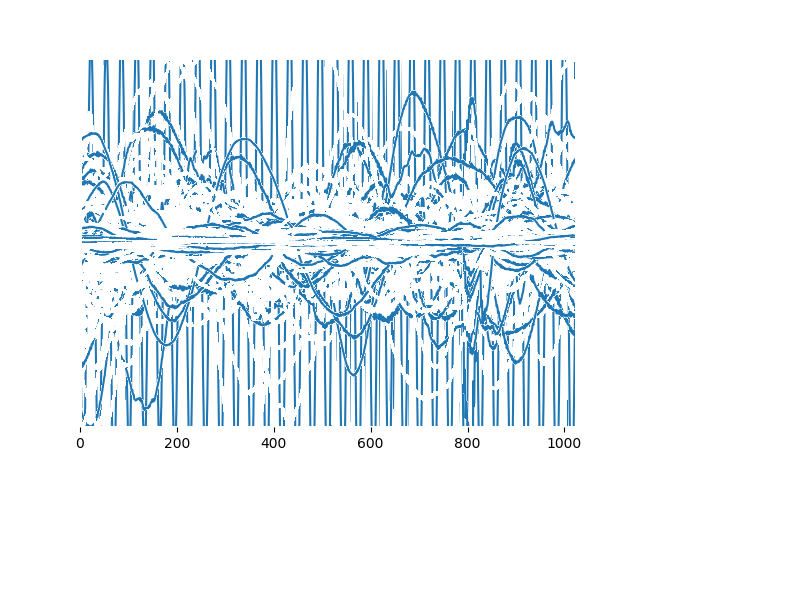

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


KeyboardInterrupt: 

In [3]:
CHUNK = 1024
RATE = 44100
CHANNELS = 2
FORMAT = pyaudio.paInt16

p=pyaudio.PyAudio()
stream=p.open(format=FORMAT,
              channels=CHANNELS,
              rate=RATE,
              input=True, 
              frames_per_buffer=CHUNK
             )

def intensity(data):
        max_amplitude_displacement = np.abs(np.max(data)-np.min(data))
        #intensity = ((max_amplitude_displacement**2)/2**20)/10         # according to square law
        intensity = ((max_amplitude_displacement)/(2**15)) * 100        # simple relationship
        return intensity

dataL = np.random.rand(CHUNK)      # initialize the dataL with random numbers
    
fig, ax = plt.subplots()
xL = np.arange(0,len(dataL))
line, = ax.plot(xL,np.random.rand(CHUNK))
ax.set_ylim(-5000,5000)
ax.set_xlim(0,CHUNK)

while True:
    data = np.fromstring(stream.read(CHUNK),dtype=np.int16)
    dataL = data[0::2]          # left channel raw data
    
    #leftIn = intensity(dataL)   # left channel intensity (0-100)
    
    line.set_ydata(dataL)
    fig.canvas.draw()
    fig.canvas.flush_events()
    
    if keyboard.is_pressed('Esc'):  # Exit the loop by pressing 'Esc'
        #print('Stoped')
        stream.stop_stream()
        stream.close()
        p.terminate()
        break
    

### Measure the intensity

The intensity of a wave can be express as <big>$I = 2\pi^2\rho f^2 v (\Delta s)^2$</big> hence <big>$I \propto (\Delta s)^2$</big>

<big>$(\Delta s)$</big> is the Amplitude Displacement. we can compare the maximum and minimum amplitude in one CHUNK and get an idea about the intensity

In [4]:
maxValue = 2**16 # 2¹⁵=32,768 Since the input exceed (+/-)this value the maximum was set to 2¹⁶(16bit resolution)
CHUNK = 1024
RATE = 44100
CHANNELS = 2
FORMAT = pyaudio.paInt16

p=pyaudio.PyAudio()
stream=p.open(format=FORMAT,
              channels=CHANNELS,
              rate=RATE,
              input=True, 
              frames_per_buffer=CHUNK
             )

# map the data between (0-100) : valid only for external mics
def intensity(data):
        max_amplitude_displacement = np.abs(np.max(data)-np.min(data))
        #intensity = ((max_amplitude_displacement**2)/2**20)/10         # according to square law
        intensity = ((max_amplitude_displacement)/(2**15)) * 100        # simple relationship
        return intensity
    
while True:
    data = np.fromstring(stream.read(CHUNK),dtype=np.int16)
    
    dataL = data[0::2]  # select even index
    dataR = data[1::2]  # select odd index
    
    # Since the intensity is propotional to the amplitude displacement
    # The maxValue is an arbitary constant with a comparable value
    peakL = np.abs(np.max(dataL)-np.min(dataL))/maxValue
    peakR = np.abs(np.max(dataR)-np.min(dataR))/maxValue
    
    #print('L:{:05.2f} R:{:05.2f}'.format(peakL*100, peakR*100))
    
    leftIn = intensity(dataL)
    rightIn = intensity(dataR)
    print('L:{:06.2f} R:{:06.2f}'.format(leftIn,rightIn))
    clear_output(wait=True)
      
    if keyboard.is_pressed('Esc'):  # Exit the loop by pressing 'Esc'
        #print('Stoped')
        stream.stop_stream()
        stream.close()
        p.terminate()
        break

L:093.12 R:092.97


### Real-time intensity visualization

In [ ]:
bars = 20
maxValue = 2**16
CHUNK = 1024
RATE = 44100
CHANNELS = 2
FORMAT = pyaudio.paInt16

p=pyaudio.PyAudio()
stream=p.open(format=FORMAT,
              channels=CHANNELS,
              rate=RATE,
              input=True, 
              frames_per_buffer=CHUNK
             )

while True:
    data = np.fromstring(stream.read(CHUNK),dtype=np.int16)
    dataL = data[0::2]
    dataR = data[1::2]
    peakL = np.abs(np.max(dataL)-np.min(dataL))/maxValue
    peakR = np.abs(np.max(dataR)-np.min(dataR))/maxValue
    
    lString = "#"*int(peakL*bars)+"-"*int(bars-peakL*bars)
    rString = "#"*int(peakR*bars)+"-"*int(bars-peakR*bars)
    
    print("L=[%s]\tR=[%s]"%(lString, rString))
    clear_output(wait=True)
    
    if keyboard.is_pressed('Esc'):  # Exit the loop by pressing 'Esc'
        stream.stop_stream()
        stream.close()
        p.terminate()
        break

L=[-------------------]	R=[-------------------]


### Append to CSV file

In [48]:
row = [4,5,6,2,6]
with open('data.csv', 'a', newline='') as csvFile:
            writer = csv.writer(csvFile)
            writer.writerow(row)

### Save <big>"raw"</big> amplitude data to a csv file with key a stroke
- Read [this](https://stackoverflow.com/questions/24072790/detect-key-press-in-python) - python keyboard methods
- Keyboard Library reference [here](https://github.com/boppreh/keyboard#keyboard.KEY_UP)

In [7]:
# Date : 22.10.2019
# version : 0.01:221019
# -> save data to a csv file with key stroke ('w')
# -> display current rading from the mics and last recorded data on the scv file


import csv
import pyaudio
import numpy as np
import keyboard
import time
from IPython.display import clear_output

CHUNK = 1024
RATE = 44100
CHANNELS = 2
FORMAT = pyaudio.paInt16

p=pyaudio.PyAudio()
stream=p.open(format=FORMAT,
              channels=CHANNELS,
              rate=RATE,
              input=True, 
              frames_per_buffer=CHUNK
             )

def MAD(data): # Maximum Amplitude Displacement in a CHUNK lengthed window
    amp = np.abs(np.max(data)-np.min(data))
    return amp
    
while True:
    data = np.fromstring(stream.read(CHUNK),dtype=np.int16)   
    data_L = data[0::2]  # select even index(left channel)
    data_R = data[1::2]  # select odd index(right channel)
    
    left = MAD(data_L)
    right = MAD(data_R)
    
    print('L:{:06} R:{:06}'.format(left,right))
    
    with open('data.csv', "r") as infile:     # Print the last recorded value 
        read = csv.reader(infile)
        data = list(read)
        idx=len(data)
        print('The last recorded val =', data[idx-1])
    
    clear_output(wait=True)
    
    if keyboard.is_pressed('Esc'):
        stream.stop_stream()
        stream.close()
        p.terminate()
        break
    
    if keyboard.is_pressed('w'):              # write to CSV
        section = 3
        row = [left, right, section]
        with open('data.csv', 'a', newline='') as csvFile:
            writer = csv.writer(csvFile)
            writer.writerow(row)
        time.sleep(.5)                        # add a delay for skipping continuous values

L:025430 R:014580
The last recorded val = ['1921', '1760', '3']
